In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import reverb
import tensorflow as tf
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.policies import actor_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver

from tf_agents.train import actor
from tf_agents.train import learner
from tf_agents.train import triggers
from tf_agents.train.utils import spec_utils
from tf_agents.train.utils import strategy_utils
from tf_agents.train.utils import train_utils
from tf_agents.utils import tensor_normalizer

from scipy.special import softmax

/tmp/ipykernel_3116343/3536933666.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-16 08:40:23.389520: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 08:40:23.389555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 08:40:23.390735: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unabl

In [2]:
sfoc1 = pd.read_csv("sfoc_combined_1.csv")
sfoc2 = pd.read_csv("sfoc_combined_2.csv")

In [3]:
uipa1 = pd.read_csv("UIPA.HMD8310H.Engine1.csv")
uipa2 = pd.read_csv("UIPA.HMD8310H.Engine2.csv")

/tmp/ipykernel_3116343/1830310476.py:1: DtypeWarning: Columns (152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,3

In [4]:
sfoc1["time"] = uipa1["time"]

In [5]:
sfoc2["time"] = uipa2["time"]

In [6]:
merged_df = pd.merge(sfoc1, sfoc2, on='time', how='inner')

<Axes: >

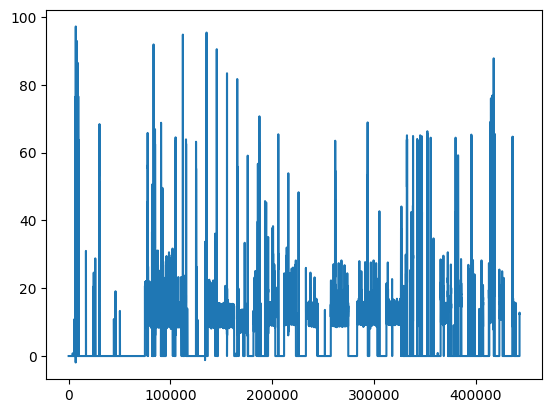

In [7]:
uipa1["aIEngineLoadPercent"].plot()

<Axes: >

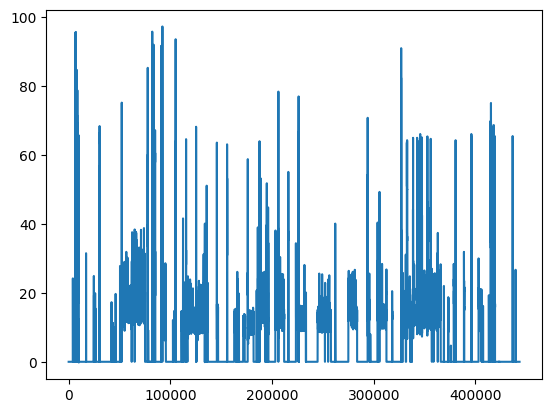

In [8]:
uipa2["aIEngineLoadPercent"].plot()

<Axes: >

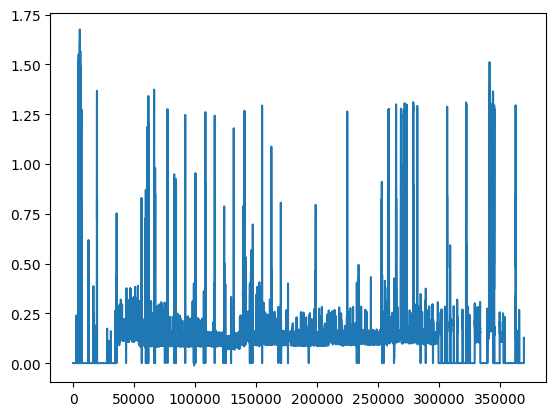

In [9]:
merged_df["total_load"] = merged_df["Engine Load_x"]+merged_df["Engine Load_y"]
merged_df["total_load"].plot()

In [10]:
merged_df.isna().sum()

Engine Load_x    1
SFOC_x           0
time             0
Engine Load_y    3
SFOC_y           0
total_load       4
dtype: int64

In [11]:
# Negative values
print(merged_df.loc[merged_df["total_load"]<0, "total_load"])
merged_df.loc[merged_df["total_load"]<0, "total_load"] = 0

98916   -0.001
99149   -0.003
99150   -0.012
99151   -0.010
Name: total_load, dtype: float64


In [12]:
merged_df.dropna(inplace=True)

In [13]:
merged_df.reset_index(drop=True, inplace=True)

In [14]:
battery = pd.read_excel("discharge_lee_ja_yun.xls")
battery

,time,AvgSOC,Current,Voltage,disconn,Power,index
0,2022-12-26T04:05:00Z,85.0,-3.5,920.0,0,-3220.0,4791
1,2022-12-26T04:06:00Z,85.0,644.5,909.0,0,585850.5,4792
2,2022-12-26T04:07:00Z,83.0,760.8,900.5,0,685100.4,4793
3,2022-12-26T04:08:00Z,82.0,746.0,896.5,0,668789.0,4794
4,2022-12-26T04:09:00Z,81.0,731.4,893.0,0,653140.2,4795
...,...,...,...,...,...,...,...
1964,2023-08-23T06:43:00Z,73.0,624.4,879.0,0,548847.6,264393
1965,2023-08-23T06:44:00Z,72.0,627.5,876.0,0,549690.0,264394
1966,2023-08-23T06:45:00Z,71.0,633.6,873.0,0,553132.8,264395
1967,2023-08-23T06:46:00Z,70.0,635.8,870.0,0,553146.0,264396


In [15]:
battery_data = pd.read_csv("EP_Battery.Thing_HMD8310.csv")

/tmp/ipykernel_3116343/4261599124.py:1: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  battery_data = pd.read_csv("EP_Battery.Thing_HMD8310.csv")


In [16]:
final_df = pd.merge(merged_df, battery_data, on='time', how='inner')
final_df.shape

(107379, 116)

In [17]:
rl_data = merged_df.loc[(merged_df["total_load"]>1.25)&(merged_df["total_load"]<1.5)].copy()
rl_data

,Engine Load_x,SFOC_x,time,Engine Load_y,SFOC_y,total_load
4695,0.682,183.4575,2022-10-26T01:43:01.001000Z,0.690,183.4575,1.372
4706,0.722,183.0000,2022-10-26T01:54:01.001000Z,0.728,183.0000,1.450
4713,0.696,183.4575,2022-10-26T02:01:01Z,0.726,183.0000,1.422
4721,0.704,183.0000,2022-10-26T02:09:01Z,0.682,183.4575,1.386
4730,0.751,183.0000,2022-10-26T02:23:01Z,0.719,183.0000,1.470
...,...,...,...,...,...,...
362542,0.640,183.9150,2023-08-23T06:42:00Z,0.642,183.9150,1.282
362543,0.635,183.9150,2023-08-23T06:43:00Z,0.645,183.9150,1.280
362544,0.634,183.9150,2023-08-23T06:44:00Z,0.641,183.9150,1.275
362545,0.634,183.9150,2023-08-23T06:45:00Z,0.631,183.9150,1.265


In [18]:
tmp = pd.merge(rl_data, battery_data, on='time', how='inner')

<Axes: >

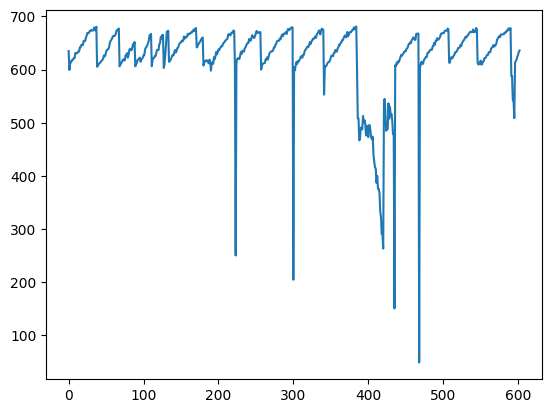

In [19]:
tmp["Current"].plot()

<Axes: >

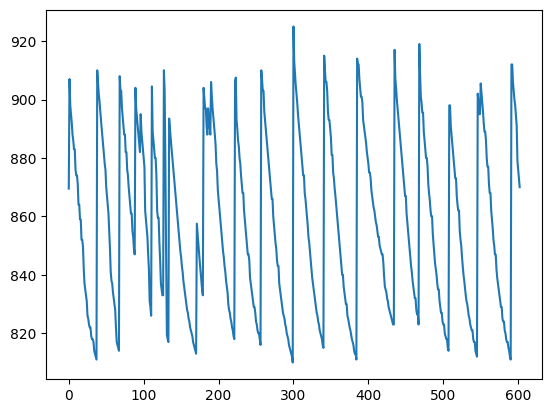

In [20]:
tmp["Voltage"].plot()

<Axes: >

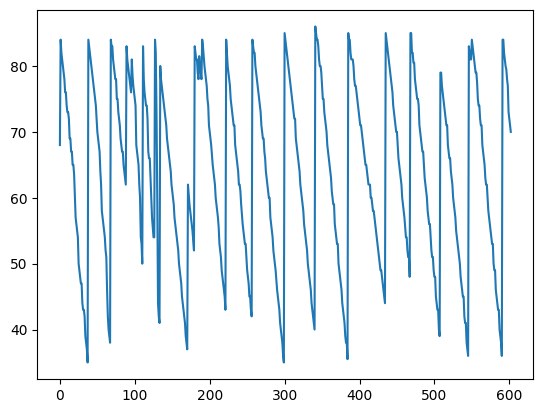

In [21]:
tmp["AvgSOC"].plot()

In [22]:
tmp["Voltage"]*tmp["Current"]

0      552045.55
1      543565.10
2      548857.60
3      549127.25
4      550676.20
         ...    
598    551172.60
599    548847.60
600    549690.00
601    553132.80
602    553146.00
Length: 603, dtype: float64

# DRL

In [23]:
# Use "num_iterations = 1e6" for better results (2 hrs)
# 1e5 is just so this doesn't take too long (1 hr)
num_iterations = 50000 # @param {type:"integer"}

initial_collect_steps = 1000 # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 100000 # @param {type:"integer"}

batch_size = 2048 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.999 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}

actor_fc_layer_params = (256, 256)
critic_joint_fc_layer_params = (256, 256)

log_interval = 5000 # @param {type:"integer"}

num_eval_episodes = 20 # @param {type:"integer"}
eval_interval = 10000 # @param {type:"integer"}

policy_save_interval = 5000 # @param {type:"integer"}

# Params for checkpoints
train_checkpoint_interval=10000
policy_checkpoint_interval=10000
rb_checkpoint_interval=10000

In [24]:
class constants:
    INVALID_ACTION = -1
    VALID_ACTION = 1
    INVALID_ACTION_REWARD = -100
    EPOCH_COMPLETE_REWARD = 0
    BATT_POWER_REWARD_FACTOR = 1
    BATT_POWER_MAX_REWARD = 1
    BATT_POWER_POWER_FACTOR = 0.4
    BAD_ACTION_REWARD = -1
    
    ENGINE_POWER_MAX_REWARD = 1
    ENGINE_POWER_REWARD_FACTOR = 1
    ENGINE_POWER_POWER_FACTOR = 0.4

In [25]:
class HybridShipEMSV3(py_environment.PyEnvironment):
    """
    Args
        driving cycle: driving cycle containing speed and motor power parameters
    Attributes
        _states [[np.float32]]: keeps all the states of an episode
        _state [np.float32]: keeps the state of the current time step of the driving cycle
        _actions [[np.float32], keeps all the actions of an episode]
        _idx (int): index of the current time step of the driving cycle
        _history {[[np.float32]]}: dictionary containing the states and actions from all iterations
    """
    def __init__(self, driving_cycle):
        self._driving_cycle = driving_cycle
        self._sampled_driving_cycle = driving_cycle
        self._sampled_driving_cycle.reset_index(drop=True, inplace=True)
        self._idx = 0
        self._state = self._sampled_driving_cycle.loc[self._idx, "total_load"]
        self._states = []
        self._states.append(self._state)
        self._actions = []
        self._episode_ended = False
        self._idx += 1
        self._history = {}
        self._history["actions"] = []
        self._history["states"] = []
        self.should_save_history = False

        # Actions: Engine1, Engine2, Battery powers
        # Softmax will be used to transform the actions into probabilities that sum up to 1
        # Battery must have lower fraction of the total total_load, because it has a maximum output of 50% of the engine only
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(2,), dtype=np.float32, minimum=[0, 0], maximum=[1, 1], name='P-eng1_P-eng2')
        # State: total_load
        states_minimum = [0]
        states_maximum = [2]
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(1,), dtype=np.float32, minimum=states_minimum, maximum=states_maximum, name='total_load')

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        if self.should_save_history:
            self._save_history()
            self.should_save_history = False
        self._reset_variables()
        return ts.restart(np.array([self._state], dtype=np.float32))
    
    def _step(self, actions):
        if self._episode_ended:
            return self.reset()
        total_load = self._state

        # Normalize actions
        actions = self._normalize_to_sum(actions, target_sum=total_load)
        P_eng1, P_eng2 = actions

        if self._is_last_timestep(self._idx):
            self._episode_ended = True
            # Dont want to motivate the state of the last timestep of the driving cycle so give reward of 0
            return ts.termination(np.array([self._state], dtype=np.float32), constants.EPOCH_COMPLETE_REWARD)
        else:
            reward1 = self._calculate_efficiency_reward(P_eng1)
            reward2 = self._calculate_efficiency_reward(P_eng2)
            reward = reward1 + reward2
            self._state = self._get_next_state()
            self._states.append(self._state)
            self._actions.append((P_eng1, P_eng2))
            return ts.transition(np.array([self._state], dtype=np.float32), reward=reward, discount=0.99)

    def _normalize_to_sum(self, values, target_sum=1.5, max_value=1):
        """
        Normalize an array of two values so that they sum up to target_sum,
        with the constraint that each value cannot be above max_value.

        :param values: List or array of two numerical values to be normalized.
        :param target_sum: The target sum for the normalized values.
        :param max_value: The maximum allowed value for each entry.
        :return: The normalized array of values.
        """
        assert len(values) == 2, "This function is designed for arrays of length 2."
        
        current_sum = sum(values)
        if current_sum == target_sum and all(v <= max_value for v in values):
            # Already meets the criteria
            return values
        
        # Scale values towards the target sum if they don't exceed the maximum
        if current_sum > 0:  # Prevent division by zero
            scaling_factor = min(target_sum / current_sum, max_value / max(values))
            values = [min(v * scaling_factor, max_value) for v in values]
        
        # Adjust if the sum doesn't meet the target due to max_value constraint
        if sum(values) != target_sum:
            if values[0] < max_value:
                values[0] = min(max_value, target_sum - values[1])
            else:
                values[1] = min(max_value, target_sum - values[0])
        
        return values

    def _is_last_timestep(self, idx):
        return idx == len(self._sampled_driving_cycle)

    def _save_history(self):
        self._history["states"].append(self._states)
        self._history["actions"].append(self._actions)

    def _reset_variables(self):
        # State at the start of the episode
        self._states = []
        self._actions = []

        self._sampled_driving_cycle = self._driving_cycle
        self._sampled_driving_cycle.reset_index(drop=True, inplace=True)
        self._idx = 0
        self._state = self._sampled_driving_cycle.loc[self._idx, "total_load"]
        self._states.append(self._state)
        self._episode_ended = False

    def _get_next_state(self):
        total_load = self._sampled_driving_cycle.loc[self._idx, "total_load"]
        self._idx += 1
        return total_load

    def _calculate_efficiency_reward(self, engine_load):
        # Define the fuel consumption rates for different loads based on your table.
        fuel_consumption_rates = {
            0.1: 1.12,
            0.15: 1.1,
            0.2: 1.085,
            0.25: 1.07,
            0.3: 1.06,
            0.35: 1.05,
            0.4: 1.035,
            0.45: 1.025,
            0.5: 1.02,
            0.55: 1.01,
            0.6: 1.005,
            0.65: 1.0025,
            0.7: 1,
            0.75: 1,
            0.8: 1.0025,
            0.9: 1.015,
            0.95: 1.02,
            1: 1.025,
        }

        # Interpolate the fuel consumption rate for the given engine load
        # Sort the keys and find where the engine load fits between two known points
        sorted_keys = sorted(fuel_consumption_rates.keys())
        for i in range(len(sorted_keys) - 1):
            if engine_load == sorted_keys[i]:
                exact_rate = fuel_consumption_rates[engine_load]
                break
            elif engine_load < sorted_keys[i + 1]:
                # Linear interpolation for fuel consumption rate
                low_key = sorted_keys[i]
                high_key = sorted_keys[i + 1]
                low_value = fuel_consumption_rates[low_key]
                high_value = fuel_consumption_rates[high_key]
                exact_rate = low_value + (high_value - low_value) * ((engine_load - low_key) / (high_key - low_key))
                break
        else:
            # Handle edge case where engine load is the highest value
            exact_rate = fuel_consumption_rates[sorted_keys[-1]]

        # Adjust the reward function to avoid too large rewards
        base_reward = 10  # Starting point for reward, adjust based on desired scale
        difference = abs(1 - exact_rate)
        scaled_reward = max(0, base_reward - (difference * 1000))  # Scale the difference impact

        return scaled_reward

In [26]:
rl_data = merged_df.loc[(merged_df["total_load"]>1.25)&(merged_df["total_load"]<1.5)].copy()

In [27]:
env = HybridShipEMSV3(rl_data)

collect_env = HybridShipEMSV3(rl_data)
eval_env = HybridShipEMSV3(rl_data)
validate_env = HybridShipEMSV3(rl_data)

/home/hanyang/Documents/battery/henry_ship_data/tf_gpu_env/lib/python3.10/site-packages/tf_agents/specs/array_spec.py:352: RuntimeWarning: invalid value encountered in cast
  self._minimum[self._minimum == -np.inf] = low
/home/hanyang/Documents/battery/henry_ship_data/tf_gpu_env/lib/python3.10/site-packages/tf_agents/specs/array_spec.py:353: RuntimeWarning: invalid value encountered in cast
  self._minimum[self._minimum == np.inf] = high
/home/hanyang/Documents/battery/henry_ship_data/tf_gpu_env/lib/python3.10/site-packages/tf_agents/specs/array_spec.py:355: RuntimeWarning: invalid value encountered in cast
  self._maximum[self._maximum == -np.inf] = low
/home/hanyang/Documents/battery/henry_ship_data/tf_gpu_env/lib/python3.10/site-packages/tf_agents/specs/array_spec.py:356: RuntimeWarning: invalid value encountered in cast
  self._maximum[self._maximum == np.inf] = high


In [28]:
utils.validate_py_environment(validate_env, episodes=10)

In [29]:
global_step = tf.compat.v1.train.get_or_create_global_step()

2024-02-16 08:41:09.738390: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-16 08:41:09.738749: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-16 08:41:09.739067: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [30]:
use_gpu = False

strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_gpu)

observation_spec, action_spec, time_step_spec = spec_utils.get_tensor_specs(collect_env)

with strategy.scope():
  critic_net = critic_network.CriticNetwork(
        (observation_spec, action_spec),
        observation_fc_layer_params=None,
        action_fc_layer_params=None,
        joint_fc_layer_params=critic_joint_fc_layer_params,
        kernel_initializer='glorot_uniform',
        last_kernel_initializer='glorot_uniform')

with strategy.scope():
  actor_net = actor_distribution_network.ActorDistributionNetwork(
      observation_spec,
      action_spec,
      fc_layer_params=actor_fc_layer_params,
      continuous_projection_net=(
          tanh_normal_projection_network.TanhNormalProjectionNetwork))


class NormalizedActorPolicy(actor_policy.ActorPolicy):
    def __init__(self, *args, **kwargs):
        super(NormalizedActorPolicy, self).__init__(
            *args,
            observation_normalizer=tensor_normalizer.EMATensorNormalizer(observation_spec),
            **kwargs
        )


with strategy.scope():

  tf_agent = sac_agent.SacAgent(
        time_step_spec,
        action_spec,
        actor_network=actor_net,
        critic_network=critic_net,
        actor_optimizer=tf.keras.optimizers.Adam(
            learning_rate=actor_learning_rate),
        critic_optimizer=tf.keras.optimizers.Adam(
            learning_rate=critic_learning_rate),
        alpha_optimizer=tf.keras.optimizers.Adam(
            learning_rate=alpha_learning_rate),
        actor_policy_ctor=NormalizedActorPolicy, # Added a normalizer: https://github.com/tensorflow/agents/issues/622
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        td_errors_loss_fn=tf.math.squared_difference,
        gamma=gamma,
        reward_scale_factor=reward_scale_factor,
        train_step_counter=global_step)

  tf_agent.initialize()

2024-02-16 08:41:13.315944: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [31]:
rate_limiter=reverb.rate_limiters.SampleToInsertRatio(samples_per_insert=3.0, min_size_to_sample=3, error_buffer=3.0)

table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1))

reverb_server = reverb.Server([table])

reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server)

dataset = reverb_replay.as_dataset(
      sample_batch_size=batch_size, num_steps=2).prefetch(50)
experience_dataset_fn = lambda: dataset

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  reverb_replay.py_client,
  table_name,
  sequence_length=2,
  stride_length=1)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmp28zzagh3.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmp28zzagh3
[reverb/cc/platform/default/server.cc:71] Started replay server on port 41431


In [32]:
tf_eval_policy = tf_agent.policy
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_eval_policy, use_tf_function=True)

tf_collect_policy = tf_agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_collect_policy, use_tf_function=True)

random_policy = random_py_policy.RandomPyPolicy(
  collect_env.time_step_spec(), collect_env.action_spec())

In [33]:
from tf_agents.policies import policy_saver
from tf_agents.utils import common

train_dir=f"checkpoints/rlV3"
tempdir=f"checkpoints/rlV3/temp"

train_checkpointer = common.Checkpointer(
    ckpt_dir=train_dir,
    agent=tf_agent,
    global_step=global_step
)
policy_checkpointer = common.Checkpointer(
    ckpt_dir=os.path.join(train_dir, 'policy'),
    policy=tf_agent.policy,
    global_step=global_step)
rb_checkpointer = common.Checkpointer(
    ckpt_dir=os.path.join(train_dir, 'replay_buffer'),
    max_to_keep=1,
    replay_buffer=reverb_replay)

train_checkpointer.initialize_or_restore()
rb_checkpointer.initialize_or_restore()

In [34]:
initial_collect_actor = actor.Actor(
  collect_env,
  random_policy,
  global_step,
  steps_per_run=initial_collect_steps,
  observers=[rb_observer])
initial_collect_actor.run()

In [35]:
env_step_metric = py_metrics.EnvironmentSteps()
collect_actor = actor.Actor(
  collect_env,
  collect_policy,
  global_step,
  steps_per_run=1,
  metrics=actor.collect_metrics(10),
  summary_dir=os.path.join(tempdir, learner.TRAIN_DIR),
  observers=[rb_observer, env_step_metric])

eval_actor = actor.Actor(
  eval_env,
  eval_policy,
  global_step,
  episodes_per_run=num_eval_episodes,
  metrics=actor.eval_metrics(num_eval_episodes),
  summary_dir=os.path.join(tempdir, 'eval'),
)

In [36]:
saved_model_dir = os.path.join(tempdir, learner.POLICY_SAVED_MODEL_DIR)

# Triggers to save the agent's policy checkpoints.
learning_triggers = [
    triggers.PolicySavedModelTrigger(
        saved_model_dir,
        tf_agent,
        global_step,
        interval=policy_save_interval),
    triggers.StepPerSecondLogTrigger(global_step, interval=10000),
]

agent_learner = learner.Learner(
  tempdir,
  global_step,
  tf_agent,
  experience_dataset_fn,
  triggers=learning_triggers,
  strategy=strategy)


In [37]:
def get_eval_metrics():
  eval_actor.run()
  results = {}
  for metric in eval_actor.metrics:
    results[metric.name] = metric.result()
  return results

metrics = get_eval_metrics()

def log_eval_metrics(step, metrics):
  eval_results = (', ').join(
      '{} = {:.6f}'.format(name, result) for name, result in metrics.items())
  print('step = {0}: {1}'.format(step, eval_results))

log_eval_metrics(0, metrics)

step = 0: AverageReturn = 9838.376953, AverageEpisodeLength = 880.000000


In [28]:
try:
  %%time
except:
  pass

# Evaluate the agent's policy once before training.
avg_return = get_eval_metrics()["AverageReturn"]
returns = [avg_return]

for _ in range(num_iterations):
  # Training.
  collect_actor.run()
  loss_info = agent_learner.run(iterations=1)

  # Evaluating.
  step = agent_learner.train_step_numpy

  if step % eval_interval == 0:
    metrics = get_eval_metrics()
    log_eval_metrics(step, metrics)
    returns.append(metrics["AverageReturn"])

  if eval_interval and step % (eval_interval*10) == 0:
    print('step = {0}: average of {1} for the past {2} steps'.format(step, sum(returns[-10:])/10, eval_interval*10))

  if step % log_interval == 0:
    collect_env.should_save_history = True
    eval_env.should_save_history = True
    print('step = {0}: loss = {1}'.format(step, loss_info.loss.numpy()))

  if step % train_checkpoint_interval == 0:
    train_checkpointer.save(global_step=step)

  if step % policy_checkpoint_interval == 0:
    policy_checkpointer.save(global_step=step)

  if step % rb_checkpoint_interval == 0:
    rb_checkpointer.save(global_step=step)

rb_observer.close()
reverb_server.stop()

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (2546567) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (2546567) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (2546567) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (2546567) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (2546567) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (2546567) so Table uniform_table is accessed directly without gRPC.


step = 5000: loss = -98.79912567138672
step = 10000: AverageReturn = 9849.745117, AverageEpisodeLength = 880.000000
step = 10000: loss = -264.53466796875
step = 15000: loss = -341.7013244628906
step = 20000: AverageReturn = 9962.329102, AverageEpisodeLength = 880.000000
step = 20000: loss = 124.16323852539062
step = 25000: loss = -335.67431640625
step = 30000: AverageReturn = 9750.884766, AverageEpisodeLength = 880.000000
step = 30000: loss = -115.39724731445312
step = 35000: loss = 167.556396484375
step = 40000: AverageReturn = 10031.443359, AverageEpisodeLength = 880.000000
step = 40000: loss = -91.1285400390625
step = 45000: loss = -227.07220458984375
step = 50000: AverageReturn = 9778.501953, AverageEpisodeLength = 880.000000
step = 50000: loss = -77.42315673828125


[reverb/cc/platform/default/server.cc:84] Shutting down replay server


In [34]:
for i in range(5):
    print(collect_env._history["actions"][5][i], collect_env._history["states"][5][i])

(0.6404739205219725, 0.7315260794780274) 1.3719999999999999
(0.7196595955960389, 0.6523404044039611) 1.3719999999999999
(0.7175617434994961, 0.7324382565005039) 1.45
(0.752033754038824, 0.6699662459611759) 1.422
(0.6514818446860351, 0.734518155313965) 1.3860000000000001


# Testing the env

In [38]:
class HybridShipEMSV3TestEnv(py_environment.PyEnvironment):
    """
    Args
        driving cycle: driving cycle containing speed and motor power parameters
    Attributes
        _states [[np.float32]]: keeps all the states of an episode
        _state [np.float32]: keeps the state of the current time step of the driving cycle
        _actions [[np.float32], keeps all the actions of an episode]
        _idx (int): index of the current time step of the driving cycle
        _history {[[np.float32]]}: dictionary containing the states and actions from all iterations
    """
    def __init__(self, driving_cycle):
        self._driving_cycle = driving_cycle
        self._sampled_driving_cycle = driving_cycle
        self._sampled_driving_cycle.reset_index(drop=True, inplace=True)
        self._idx = 0
        self._state = self._sampled_driving_cycle.loc[self._idx, "total_load"]
        self._states = []
        self._states.append(self._state)
        self._actions = []
        self._episode_ended = False
        self._idx += 1
        self._history = {}
        self._history["actions"] = []
        self._history["states"] = []
        self.should_save_history = False

        # Actions: Engine1, Engine2, Battery powers
        # Softmax will be used to transform the actions into probabilities that sum up to 1
        # Battery must have lower fraction of the total total_load, because it has a maximum output of 50% of the engine only
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(2,), dtype=np.float32, minimum=[0, 0], maximum=[1, 1], name='P-eng1_P-eng2')
        # State: total_load
        states_minimum = [0]
        states_maximum = [2]
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(1,), dtype=np.float32, minimum=states_minimum, maximum=states_maximum, name='total_load')

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        if self.should_save_history:
            self._save_history()
            self.should_save_history = False
        self._reset_variables()
        return ts.restart(np.array([self._state], dtype=np.float32))
    
    def _step(self, actions):
        if self._episode_ended:
            return self.reset()
        total_load = self._state

        # Normalize actions
        actions = self._normalize_to_sum(actions, target_sum=total_load)
        P_eng1, P_eng2 = actions
        # print(P_eng1, P_eng2, total_load)

        if self._is_last_timestep(self._idx):
            self._episode_ended = True
            # Dont want to motivate the state of the last timestep of the driving cycle so give reward of 0
            return ts.termination(np.array([self._state], dtype=np.float32), constants.EPOCH_COMPLETE_REWARD)
        else:
            reward1 = self._calculate_efficiency_reward(P_eng1)
            reward2 = self._calculate_efficiency_reward(P_eng2)
            reward = reward1 + reward2
            self._state = self._get_next_state()
            self._states.append(self._state)
            self._actions.append((P_eng1, P_eng2))
            return ts.transition(np.array([self._state], dtype=np.float32), reward=reward, discount=0.99)

    def _normalize_to_sum(self, values, target_sum=1.5, max_value=1):
        """
        Normalize an array of two values so that they sum up to target_sum,
        with the constraint that each value cannot be above max_value.

        :param values: List or array of two numerical values to be normalized.
        :param target_sum: The target sum for the normalized values.
        :param max_value: The maximum allowed value for each entry.
        :return: The normalized array of values.
        """
        assert len(values) == 2, "This function is designed for arrays of length 2."
        
        current_sum = sum(values)
        if current_sum == target_sum and all(v <= max_value for v in values):
            # Already meets the criteria
            return values
        
        # Scale values towards the target sum if they don't exceed the maximum
        if current_sum > 0:  # Prevent division by zero
            scaling_factor = min(target_sum / current_sum, max_value / max(values))
            values = [min(v * scaling_factor, max_value) for v in values]
        
        # Adjust if the sum doesn't meet the target due to max_value constraint
        if sum(values) != target_sum:
            if values[0] < max_value:
                values[0] = min(max_value, target_sum - values[1])
            else:
                values[1] = min(max_value, target_sum - values[0])
        
        return values

    def _is_last_timestep(self, idx):
        return idx == len(self._sampled_driving_cycle)

    def _save_history(self):
        self._history["states"].append(self._states)
        self._history["actions"].append(self._actions)

    def _reset_variables(self):
        # State at the start of the episode
        self._states = []
        self._actions = []

        self._sampled_driving_cycle = self._driving_cycle
        self._sampled_driving_cycle.reset_index(drop=True, inplace=True)
        self._idx = 0
        self._state = self._sampled_driving_cycle.loc[self._idx, "total_load"]
        self._states.append(self._state)
        self._episode_ended = False

    def _get_next_state(self):
        total_load = self._sampled_driving_cycle.loc[self._idx, "total_load"]
        self._idx += 1
        return total_load

    def _calculate_efficiency_reward(self, engine_load):
        # Define the fuel consumption rates for different loads based on your table.
        fuel_consumption_rates = {
            0.1: 1.12,
            0.15: 1.1,
            0.2: 1.085,
            0.25: 1.07,
            0.3: 1.06,
            0.35: 1.05,
            0.4: 1.035,
            0.45: 1.025,
            0.5: 1.02,
            0.55: 1.01,
            0.6: 1.005,
            0.65: 1.0025,
            0.7: 1,
            0.75: 1,
            0.8: 1.0025,
            0.9: 1.015,
            0.95: 1.02,
            1: 1.025,
        }

        # Interpolate the fuel consumption rate for the given engine load
        # Sort the keys and find where the engine load fits between two known points
        sorted_keys = sorted(fuel_consumption_rates.keys())
        for i in range(len(sorted_keys) - 1):
            if engine_load == sorted_keys[i]:
                exact_rate = fuel_consumption_rates[engine_load]
                break
            elif engine_load < sorted_keys[i + 1]:
                # Linear interpolation for fuel consumption rate
                low_key = sorted_keys[i]
                high_key = sorted_keys[i + 1]
                low_value = fuel_consumption_rates[low_key]
                high_value = fuel_consumption_rates[high_key]
                exact_rate = low_value + (high_value - low_value) * ((engine_load - low_key) / (high_key - low_key))
                break
        else:
            # Handle edge case where engine load is the highest value
            exact_rate = fuel_consumption_rates[sorted_keys[-1]]

        # Adjust the reward function to avoid too large rewards
        base_reward = 10  # Starting point for reward, adjust based on desired scale
        difference = abs(1 - exact_rate)
        scaled_reward = max(0, base_reward - (difference * 1000))  # Scale the difference impact

        return scaled_reward

In [39]:
def compute_viz(environment, policy, num_episodes=10):

    total_return = 0.0
    policy_state = policy.get_initial_state(environment.batch_size)
#     print(f"Initial: {policy_state}")

    best_episode_returns = {}
    episode_max_reward = -np.inf

    for i in range(num_episodes):
        episode_load_powers = []
        episode_P_eng1 = []
        episode_P_eng2 = []
        episode_rewards = []
        time_step = environment.reset()
        episode_reward = 0.0
        step = 0
#         print("Step: 0")
        last_time_step = len(environment._driving_cycle["total_load"])
        while not time_step.is_last():
            observation = time_step[3]
            load_power = observation[0]
            if (step % 440) == 0:
                print("---\nStep: {}".format(step))
            action_step = policy.action(time_step, policy_state)
            # print(load_power, P_eng1, P_eng2)
            time_step = environment.step(action_step.action)
            policy_state = action_step.state
#             print("States: {}".format(observation))
            episode_reward += time_step.reward
            EMS_powers = action_step.action
            P_eng1 = EMS_powers[0]
            P_eng2 = EMS_powers[1]
            print(load_power, P_eng1, P_eng2)
            episode_load_powers.append(load_power)
            episode_P_eng1.append(P_eng1)
            episode_P_eng2.append(P_eng2)

            episode_rewards.append(episode_reward)
#             print("Reward: {} \n".format(episode_reward))
            step += 1
        print(f"Episode {i}")
        print("Reward: {} \n".format(episode_reward))
        if np.max(episode_rewards) > episode_max_reward:
            episode_max_reward = np.max(episode_rewards)
            best_episode_returns["load_power"] = episode_load_powers
            best_episode_returns["P_eng1"] = episode_P_eng1
            best_episode_returns["P_eng2"] = episode_P_eng2
            best_episode_returns["rewards"] = episode_rewards
        total_return += episode_reward

    avg_return = total_return / num_episodes
    print("Best episode rewards: {}\n".format(best_episode_returns["rewards"][-1]))

    return avg_return, best_episode_returns


print(f"Test data")
best_episode_return = None
episode_max_return = -np.inf

# Reset the train step
tf_agent.train_step_counter.assign(0)

tmp = rl_data
test_env = HybridShipEMSV3TestEnv(tmp)

# reset test environment
test_env.reset()

# Evaluate the tf_agent's policy once before training.
avg_return, best_episode_returns = compute_viz(test_env, tf_agent.policy, 1)

df = pd.DataFrame(best_episode_returns)

df.to_csv(f"drl_sfoc_results/rewards.csv", index=False)

# folder = f"mni_driving_cycle_prediction/data/{route}_dataset"
# filename = f"{route}_best_episode_returns{i}.csv"

# df.to_csv(f"{folder}/{filename}", index=False)
#     for episode_return in episode_returns:
#         if np.max(episode_return) > episode_max_return:
#             episode_max_return = np.max(episode_return)
#             best_episode_return = episode_return
#     avg_returns.append(avg_return)
#     best_episode_returns.append(best_episode_return)

Test data
---
Step: 0
1.372 tf.Tensor(0.8507676, shape=(), dtype=float32) tf.Tensor(0.8514887, shape=(), dtype=float32)
1.372 tf.Tensor(0.7344912, shape=(), dtype=float32) tf.Tensor(0.8624792, shape=(), dtype=float32)
1.45 tf.Tensor(0.82676554, shape=(), dtype=float32) tf.Tensor(0.94435763, shape=(), dtype=float32)
1.422 tf.Tensor(0.66314876, shape=(), dtype=float32) tf.Tensor(0.88155115, shape=(), dtype=float32)
1.386 tf.Tensor(0.77098787, shape=(), dtype=float32) tf.Tensor(0.68603426, shape=(), dtype=float32)
1.47 tf.Tensor(0.774202, shape=(), dtype=float32) tf.Tensor(0.8890866, shape=(), dtype=float32)
1.379 tf.Tensor(0.807308, shape=(), dtype=float32) tf.Tensor(0.49768937, shape=(), dtype=float32)
1.318 tf.Tensor(0.7957655, shape=(), dtype=float32) tf.Tensor(0.86273575, shape=(), dtype=float32)
1.472 tf.Tensor(0.7853401, shape=(), dtype=float32) tf.Tensor(0.75990856, shape=(), dtype=float32)
1.453 tf.Tensor(0.80542886, shape=(), dtype=float32) tf.Tensor(0.9590483, shape=(), dtype=f

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f28cacb9000>>
Traceback (most recent call last):
  File "/home/hanyang/Documents/battery/henry_ship_data/tf_gpu_env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


1.251 tf.Tensor(0.8170351, shape=(), dtype=float32) tf.Tensor(0.36597705, shape=(), dtype=float32)
1.267 tf.Tensor(0.49212685, shape=(), dtype=float32) tf.Tensor(0.92781746, shape=(), dtype=float32)
1.257 tf.Tensor(0.91924584, shape=(), dtype=float32) tf.Tensor(0.9008519, shape=(), dtype=float32)
1.252 tf.Tensor(0.8776799, shape=(), dtype=float32) tf.Tensor(0.91292536, shape=(), dtype=float32)
1.256 tf.Tensor(0.737683, shape=(), dtype=float32) tf.Tensor(0.6655802, shape=(), dtype=float32)
1.26 tf.Tensor(0.74662936, shape=(), dtype=float32) tf.Tensor(0.5983778, shape=(), dtype=float32)
1.26 tf.Tensor(0.6623529, shape=(), dtype=float32) tf.Tensor(0.6978768, shape=(), dtype=float32)
1.258 tf.Tensor(0.83590543, shape=(), dtype=float32) tf.Tensor(0.50230914, shape=(), dtype=float32)
1.267 tf.Tensor(0.66141474, shape=(), dtype=float32) tf.Tensor(0.92725956, shape=(), dtype=float32)
1.293 tf.Tensor(0.87330717, shape=(), dtype=float32) tf.Tensor(0.7499945, shape=(), dtype=float32)
1.263 tf.Ten

KeyboardInterrupt: 

In [39]:
tmp = rl_data
test_env = HybridShipEMSV3TestEnv(tmp)

num_episodes = 10  # Number of episodes for testing

# Lists to store results
all_returns = []
all_actions = []
all_states = []

for episode in range(num_episodes):
    episode_actions = []
    episode_states = []
    episode_return = 0.0

    time_step = test_env.reset()
    
    test_env.should_save_history = True

    episode_states.append(time_step.observation.item())  # Store the initial state

    step = 0

    best_episode_returns = {}
    episode_max_reward = -np.inf
    
    while not time_step.is_last():
        if (step % 440) == 0:
            print("---\nStep: {}".format(step))
        # Generate an action from the policy
        action_step = tf_agent.policy.action(time_step)
        
        # Store the action
        episode_actions.append(action_step.action.numpy())

        # Apply the action to the environment and get the next time_step
        time_step = test_env.step(action_step.action)

        # Store the next state
        episode_states.append(time_step.observation.item())

        # Accumulate the reward
        episode_return += time_step.reward.item()
        step += 1

    # Store the results for this episode
    all_returns.append(episode_return)
    all_actions.append(episode_actions)
    all_states.append(episode_states)
    print(f"Episode {episode}")
    print("Reward: {} \n".format(episode_return))

    if np.max(episode_return) > episode_max_reward:
        episode_max_reward = episode_return
        best_episode_returns["load_power"] = test_env._states
        best_episode_returns["actions"] = test_env._actions
        best_episode_returns["rewards"] = episode_return

# Calculate and print the average return
average_return = np.mean(all_returns)
print(f'Average return over {num_episodes} episodes: {average_return}')

---
Step: 0
---
Step: 440
Episode 0
Reward: 9545.958346366882 

---
Step: 0
---
Step: 440
Episode 1
Reward: 10063.68818283081 

---
Step: 0
---
Step: 440
Episode 2
Reward: 9555.237243652344 

---
Step: 0
---
Step: 440
Episode 3
Reward: 9970.950432777405 

---
Step: 0
---
Step: 440
Episode 4
Reward: 9610.780091285706 

---
Step: 0
---
Step: 440
Episode 5
Reward: 10046.820885658264 

---
Step: 0
---
Step: 440
Episode 6
Reward: 9593.2592086792 

---
Step: 0
---
Step: 440
Episode 7
Reward: 9905.425325393677 

---
Step: 0
---
Step: 440
Episode 8
Reward: 10075.692058563232 

---
Step: 0
---
Step: 440
Episode 9
Reward: 9858.494210243225 

Average return over 10 episodes: 9822.630598545074


In [40]:
tmp = best_episode_returns.copy()

In [41]:
def calculate_efficiency(engine_load):
    # Define the fuel consumption rates for different loads based on your table.
    fuel_consumption_rates = {
        0.1: 1.12,
        0.15: 1.1,
        0.2: 1.085,
        0.25: 1.07,
        0.3: 1.06,
        0.35: 1.05,
        0.4: 1.035,
        0.45: 1.025,
        0.5: 1.02,
        0.55: 1.01,
        0.6: 1.005,
        0.65: 1.0025,
        0.7: 1,
        0.75: 1,
        0.8: 1.0025,
        0.9: 1.015,
        0.95: 1.02,
        1: 1.025,
    }

    # Interpolate the fuel consumption rate for the given engine load
    # Sort the keys and find where the engine load fits between two known points
    sorted_keys = sorted(fuel_consumption_rates.keys())
    for i in range(len(sorted_keys) - 1):
        if engine_load == sorted_keys[i]:
            exact_rate = fuel_consumption_rates[engine_load]
            break
        elif engine_load < sorted_keys[i + 1]:
            # Linear interpolation for fuel consumption rate
            low_key = sorted_keys[i]
            high_key = sorted_keys[i + 1]
            low_value = fuel_consumption_rates[low_key]
            high_value = fuel_consumption_rates[high_key]
            exact_rate = low_value + (high_value - low_value) * ((engine_load - low_key) / (high_key - low_key))
            break
    else:
        # Handle edge case where engine load is the highest value
        exact_rate = fuel_consumption_rates[sorted_keys[-1]]

    return exact_rate

load_powers = tmp["load_power"]
actions = tmp["actions"]
tmp["sfoc1"] = []
tmp["sfoc2"] = []

for i in range(len(actions)):
    try:
        P_eng1 = actions[i][0].numpy()
    except:
        P_eng1 = actions[i][0]
    try:
        P_eng2 = actions[i][1].numpy()
    except:
        P_eng2 = actions[i][1]
    relative_sfoc1 = calculate_efficiency(P_eng1)
    relative_sfoc2 = calculate_efficiency(P_eng2)
    
    tmp["sfoc1"].append(relative_sfoc1 * 183)
    tmp["sfoc2"].append(relative_sfoc2 * 183)

183.64591296928327

In [42]:
print(np.mean(tmp["sfoc1"]))
print(np.mean(tmp["sfoc2"]))

184.33305024735654
184.49554246432442


In [43]:
print(np.mean(tmp["actions"]))

0.6553942


In [61]:
P_eng1 = []
P_eng2 = []
for action in tmp["actions"]:
    P_eng1.append(action[0].numpy())
    P_eng2.append(action[1].numpy())

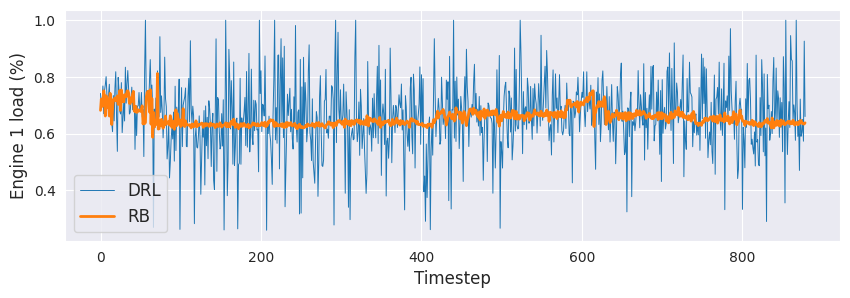

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

plt.figure(figsize=((10,3 )))
pd.Series(P_eng1).plot(linewidth=0.7)
rl_data["Engine Load_x"].plot(linewidth=2)

plt.legend(["DRL", "RB"], fontsize=12)
plt.xticks(fontsize=10)  # Adjust x-ticks font size
plt.yticks(fontsize=10)  # Adjust y-ticks font size
plt.xlabel('Timestep', fontsize=12)
_ = plt.ylabel('Engine 1 load (%)', fontsize=12)

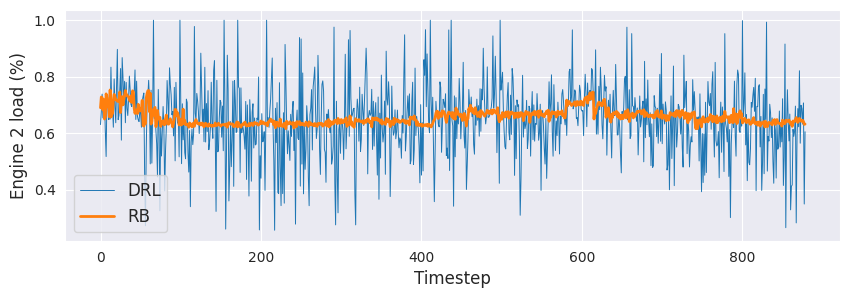

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

plt.figure(figsize=((10,3 )))
pd.Series(P_eng2).plot(linewidth=0.7)
rl_data["Engine Load_y"].plot(linewidth=2)

plt.legend(["DRL", "RB"], fontsize=12)
plt.xticks(fontsize=10)  # Adjust x-ticks font size
plt.yticks(fontsize=10)  # Adjust y-ticks font size
plt.xlabel('Timestep', fontsize=12)
_ = plt.ylabel('Engine 2 load (%)', fontsize=12)

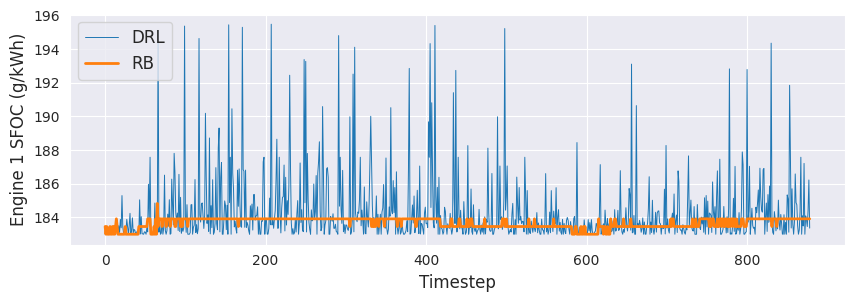

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

plt.figure(figsize=((10,3 )))
pd.Series(tmp["sfoc1"]).plot(linewidth=0.7)
rl_data["SFOC_x"].plot(linewidth=2)

plt.legend(["DRL", "RB"], fontsize=12)
plt.xticks(fontsize=10)  # Adjust x-ticks font size
plt.yticks(fontsize=10)  # Adjust y-ticks font size
plt.xlabel('Timestep', fontsize=12)
_ = plt.ylabel('Engine 1 SFOC (g/kWh)', fontsize=12)

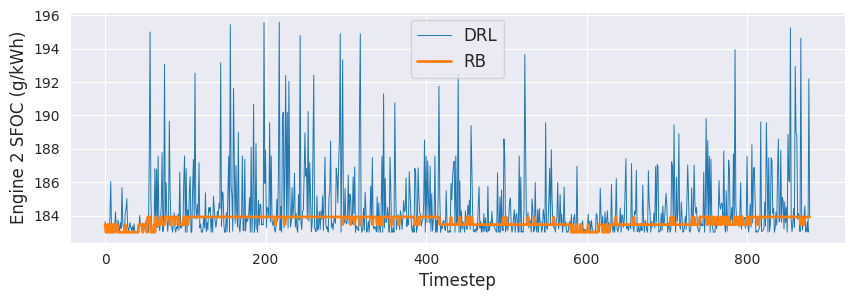

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

plt.figure(figsize=((10,3 )))
pd.Series(tmp["sfoc2"]).plot(linewidth=0.7)
rl_data["SFOC_y"].plot(linewidth=2)

plt.legend(["DRL", "RB"], fontsize=12)
plt.xticks(fontsize=10)  # Adjust x-ticks font size
plt.yticks(fontsize=10)  # Adjust y-ticks font size
plt.xlabel('Timestep', fontsize=12)
_ = plt.ylabel('Engine 2 SFOC (g/kWh)', fontsize=12)

In [ ]:
rl_data["Engine Load_x"]

In [87]:
print(np.mean(P_eng1))
print(rl_data["Engine Load_x"].mean())
print()
print(np.mean(P_eng2))
print(rl_data["Engine Load_y"].mean())

0.66384715
0.6548498293515359

0.6469411
0.6558225255972697


In [86]:
print(np.mean(tmp["sfoc1"]))
print(rl_data["SFOC_x"].mean())
print()
print(np.mean(tmp["sfoc2"]))
print(rl_data["SFOC_y"].mean())

184.33305024735654
183.66673208191125

184.49554246432442
183.64591296928327


In [43]:
for i in range(5):
    print(np.sum(test_env._actions[i]), test_env._states[i])

1.2375629 1.3719999999999999
1.5277791 1.3719999999999999
1.3027542 1.45
1.791323 1.422
1.3172095 1.3860000000000001


In [32]:
df

,load_power,P_eng1,P_eng2,rewards
0,1.372,"tf.Tensor(0.5192796, shape=(), dtype=float32)","tf.Tensor(0.39932862, shape=(), dtype=float32)",0.000000
1,1.372,"tf.Tensor(0.83908045, shape=(), dtype=float32)","tf.Tensor(0.7626811, shape=(), dtype=float32)",11.980791
2,1.450,"tf.Tensor(0.8729361, shape=(), dtype=float32)","tf.Tensor(0.7662932, shape=(), dtype=float32)",21.166115
3,1.422,"tf.Tensor(0.8585036, shape=(), dtype=float32)","tf.Tensor(0.5296886, shape=(), dtype=float32)",21.353164
4,1.386,"tf.Tensor(0.4558323, shape=(), dtype=float32)","tf.Tensor(0.7182857, shape=(), dtype=float32)",31.353164
...,...,...,...,...
875,1.282,"tf.Tensor(0.69975173, shape=(), dtype=float32)","tf.Tensor(0.58874357, shape=(), dtype=float32)",9201.238401
876,1.280,"tf.Tensor(0.9718032, shape=(), dtype=float32)","tf.Tensor(0.6009815, shape=(), dtype=float32)",9206.287520
877,1.275,"tf.Tensor(0.66523755, shape=(), dtype=float32)","tf.Tensor(0.41168225, shape=(), dtype=float32)",9214.549330
878,1.265,"tf.Tensor(0.7433241, shape=(), dtype=float32)","tf.Tensor(0.74840885, shape=(), dtype=float32)",9234.549330
